In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.CIFAR10(root='datasets', train=True, download=True, transform=transform)

Files already downloaded and verified


In [5]:
test_data = datasets.CIFAR10(root='datasets', train=False, download=True, transform=transform)

Files already downloaded and verified


In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: datasets
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [9]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [10]:
for images, labels in train_loader:
    break

In [11]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

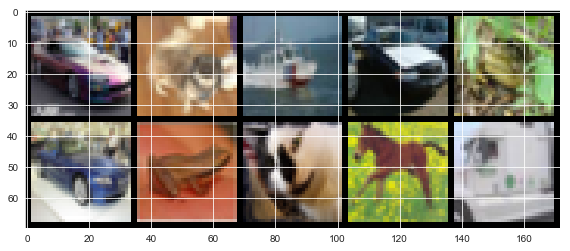

In [12]:
im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [13]:
class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)#(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16*6*6)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [14]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
69120
120
10080
84
840
10


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
import time
start_time = time.time()

# Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#For loop epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader): #X_train = 1 x 28 x 28, y_train = label
        b+=1

        # Train
        y_pred = model(X_train) # Not flattened due to conv2D
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1] #predicted labels as a 1d tensor
        batch_corr = (predicted == y_train).sum() #if these predicted labels of 1d tensor == y_train or actual values, this ends up being 1d tensor of values then summed.
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)

            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_pred, y_train)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")



epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.05384052  accuracy:  53.690%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.08301961  accuracy:  54.640%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.41579711  accuracy:  54.833%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 0.71307099  accuracy:  54.913%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.07591534  accuracy:  55.414%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.59148157  accuracy:  59.080%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 2.08063436  accuracy:  59.390%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.57781613  accuracy:  59.200%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.15233397  accuracy:  59.112%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.31890798  accuracy:  59.204%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.32335508  accuracy:  61.530%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.68348294  accuracy:  61.460%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.45183349  accuracy:  61.700%
epoch:  2  b

In [20]:
torch.save(model.state_dict(), 'myCIFARmodel.pt')

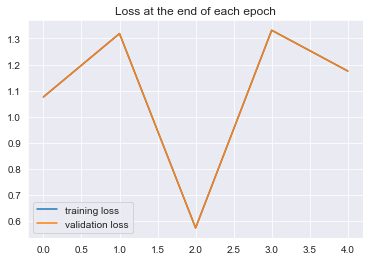

In [21]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

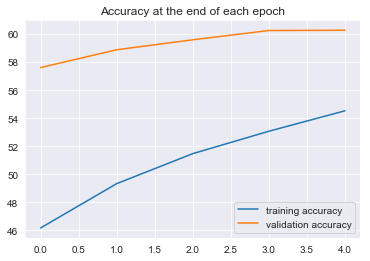

In [22]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [23]:
print(test_correct)

[tensor(5761), tensor(5888), tensor(5959), tensor(6025), tensor(6027)]


In [24]:
num_c = test_correct[-1].item()

In [25]:
num_c * 100 / 10000

60.27

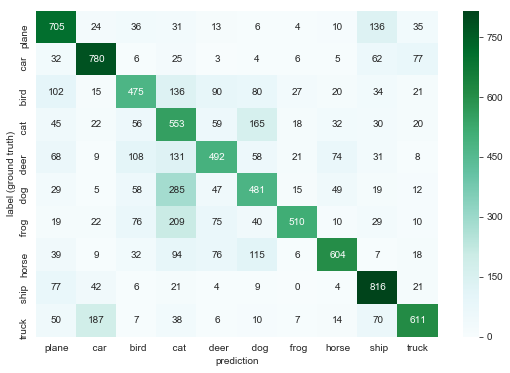

In [31]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [46]:
correct.item()/len(test_data)

0.9879

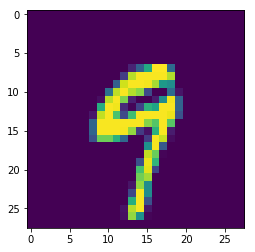

In [47]:
plt.imshow(test_data[2019][0].reshape(28, 28))

In [48]:
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2019][0].view(1, 1, 28, 28))

In [49]:
new_prediction.argmax()

tensor(9)